# Kaggle필사중
### I study the data analysis by looking and re-writing the below kaggle kernel one by one.
### https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

# 1. Introduction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 2. Load and check data
### 2.2 Load data

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
IDtest = test['PassengerId']

### 2.2 Outlier detection

In [4]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of dinices corresponding to the observations containing more than n outliers according to the Turkey method.
    """
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range(IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of ouliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more tahn 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers
    
# dectect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
        

In [5]:
train.loc[Outliers_to_drop] # show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [7]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
877,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
879,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### 2.3 Joining train and test set

In [8]:
# Join train and test datasets in order to obtain the same number of features during categorical conversion

train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### 2.4 Check for null and missing values

In [9]:
# fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# check for Null Values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [10]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [13]:
# summarize data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis
### 3.1 Numerical values

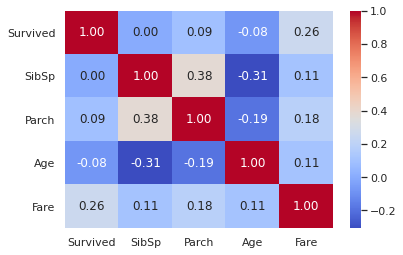

In [14]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

/home/rayjang/.local/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/rayjang/.local/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


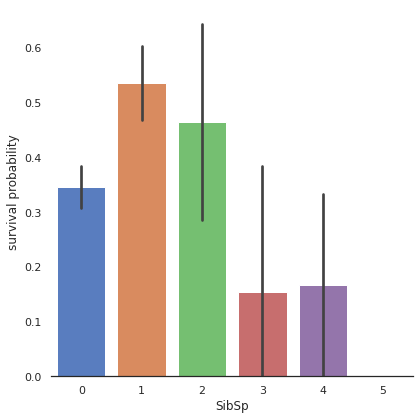

In [15]:
# SibSP

# Explore SibSp feature vs. SUrvived
g = sns.factorplot(x="SibSp", y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

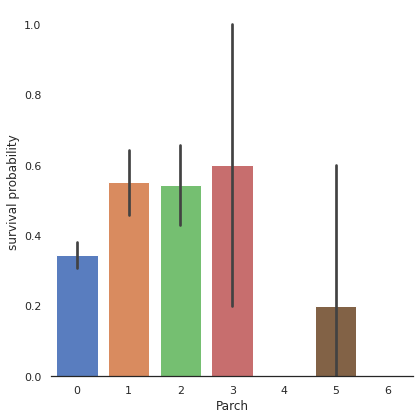

In [16]:
# Parch

# Explore Parch feature vs. Survived
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

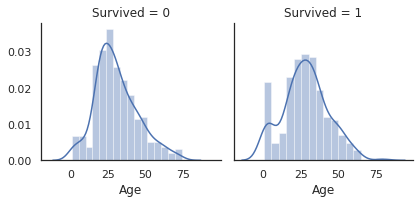

In [19]:
# Age

# Explore Age vs. Survivied
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

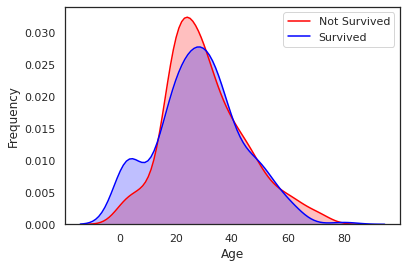

In [21]:
# Explore Age distribution

g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Survived'].notnull())], color='Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Survived'].notnull())], color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [22]:
# Fare

In [23]:
dataset['Fare'].isnull().sum()

1

In [24]:
# Fill Fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

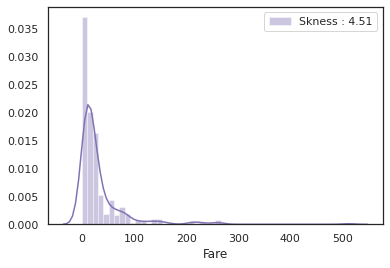

In [25]:
# Explore Fare distribution
g = sns.distplot(dataset['Fare'], color='m', label='Skness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

In [27]:
# apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i >0 else 0)

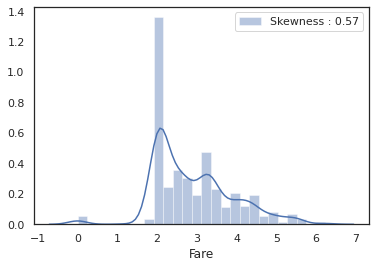

In [28]:
g = sns.distplot(dataset['Fare'], color='b', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

### 3.2 Categorical values

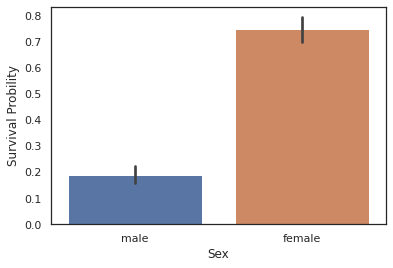

In [29]:
# sex

g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probility')

In [30]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


/home/rayjang/.local/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/rayjang/.local/lib/python3.6/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


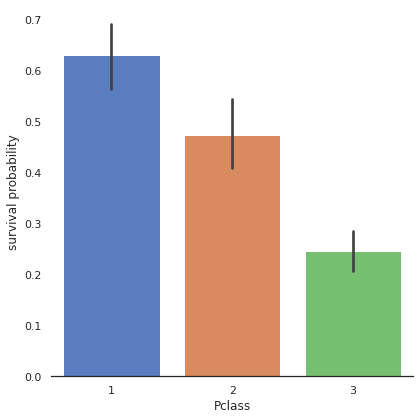

In [31]:
# PClass

# Explore Pclass vs. Survived
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

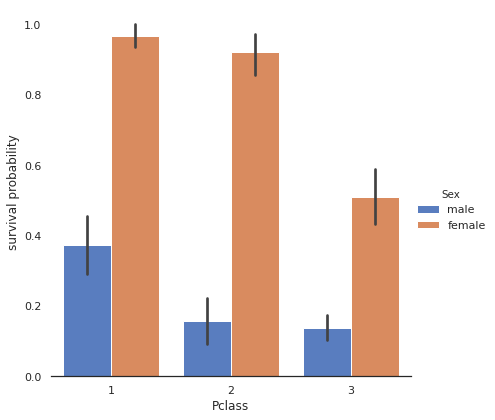

In [32]:
# Explore Pclass vs. Survived by Sex
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

In [33]:
# Embarked
dataset['Embarked'].isnull().sum()

2

In [34]:
# Fill Embarked nan values of dataset with 'S' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

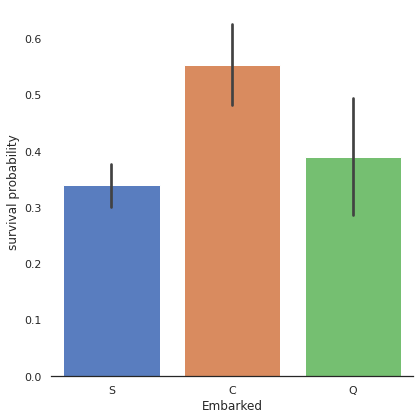

In [35]:
# Explore Embarked vs. Survived
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

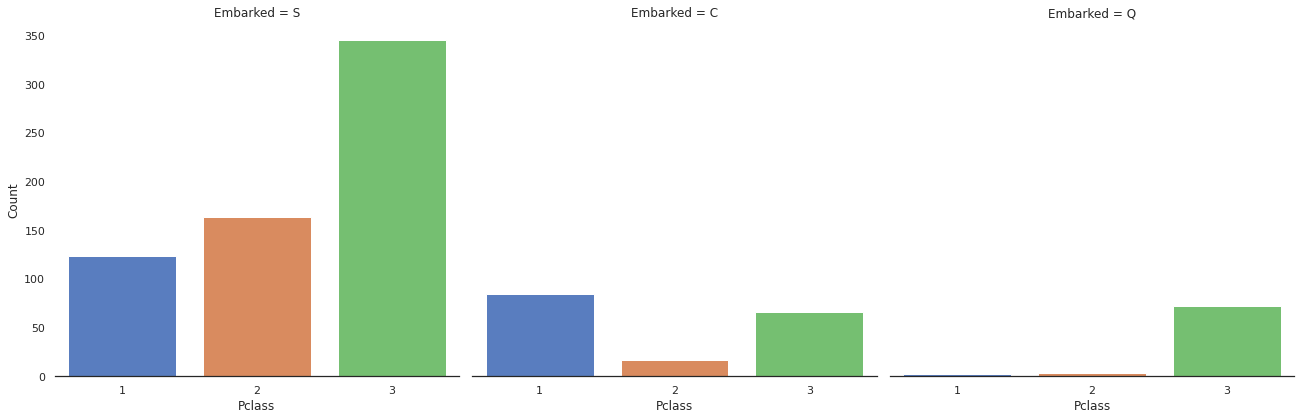

In [36]:
# Explore Pclass vs. Embarked
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

# 4. Filling missing values
### 4.1 Age

/home/rayjang/.local/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/rayjang/.local/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/rayjang/.local/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catpl

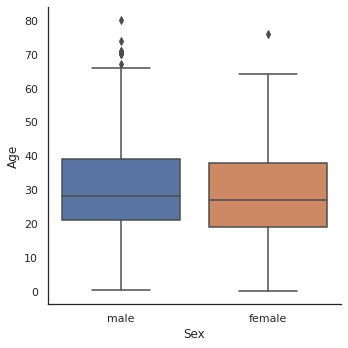

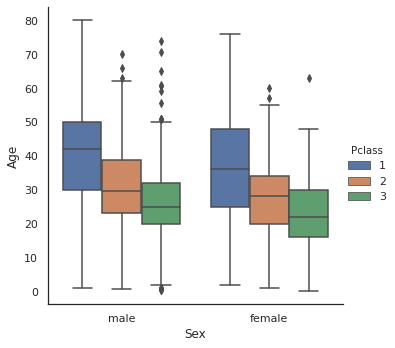

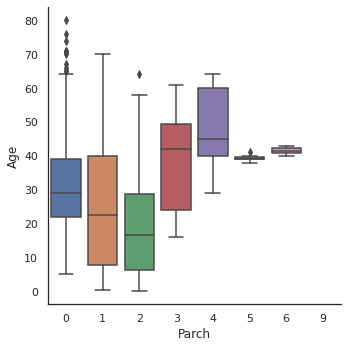

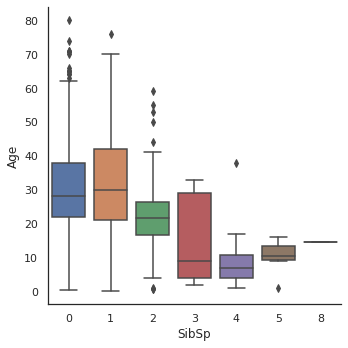

In [37]:
# Explore Age vs Sex, Pclass and SibSP

g = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

In [38]:
# convert Sex info into categorical value o for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male' : 0, 'female' : 1})

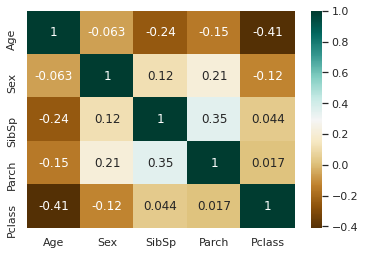

In [40]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

In [42]:
# Filling missing values of Age.

# Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Parch'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/home/rayjang/.local/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
